In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from adaptive_latents import (
    Pipeline, 
    CenteringTransformer, 
    proSVD, 
    sjPCA, 
    AnimationManager, 
    KernelSmoother, 
    SwitchingParallelTransformer, 
    mmICA, 
    VanillaOnlineRegressor, 
    NumpyTimedDataSource,
)

import adaptive_latents.plotting_functions as pf
from adaptive_latents import datasets


In [2]:
d  = datasets.Zong22Dataset(2)

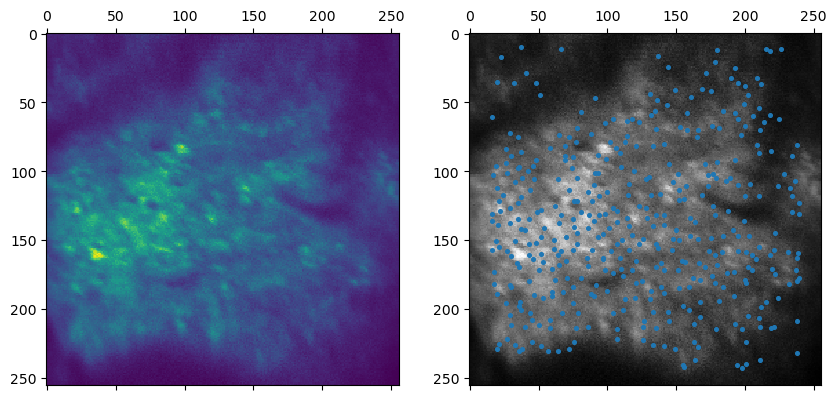

In [3]:
planes = []
for i in range(500):
    d.raw_images.seek(i)
    planes.append(np.array(d.raw_images))
    
im = np.mean(planes, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(im)

axs[1].matshow(-im, cmap='Grays')
xs, ys = list(zip(*[cell['med'] for cell in d.stat]))
axs[1].scatter(ys,xs, s=7)
# plt.colorbar()


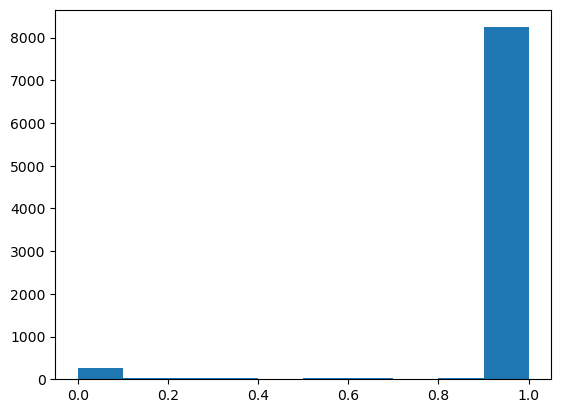

In [19]:
plt.hist(d.behavior_df.nose_likelihood);

In [16]:
d = datasets.Zong22Dataset(2)

p1 = Pipeline([
    CenteringTransformer(),
    KernelSmoother(.2*d.neural_Fs),
    proSVD(k=6),
])

p1.offline_run_on([d.neural_data])
p1.freeze()
p1.steps[1] = KernelSmoother(tau=p1.steps[1].tau)

p2 = Pipeline([
    p1,
    VanillaOnlineRegressor(log_level=1)
])



p2.offline_run_on([d.neural_data, d.behavioral_data])


array([[ 50.79202633, 364.23285728,  -2.62639563,  40.50636507],
       [ 52.94707023, 366.20649401,  -2.82317455,  39.78213502],
       [ 51.30432697, 370.28167946,  -3.0715474 ,  37.25372381],
       ...,
       [506.13865295, 121.43209511,  -1.31635205,  38.1521934 ],
       [497.24864812,  96.62385133,  -1.3499353 ,  38.29765234],
       [519.69752358,  86.01216594,  -1.39085042,  38.12057717]])

In [27]:
%matplotlib inline
reg: VanillaOnlineRegressor = p2.steps[1]

reg.get_beta().shape

(7, 4)

In [8]:
for sub_dataset in datasets.Zong22Dataset.sub_datasets:
    d = datasets.Zong22Dataset(sub_dataset)
    try:
        for i in [0,1]:
            p_prosvd = Pipeline([
                CenteringTransformer(),
                KernelSmoother(.2*d.neural_Fs),
                proSVD(k=6),
            ])

            temp_p = Pipeline([
                p_prosvd,
                SwitchingParallelTransformer([jpca := sjPCA(), ica := mmICA()])
            ])

            if i == 1:
                temp_p.offline_run_on([d.neural_data])
                temp_p.freeze()
                p_prosvd.steps[1] = KernelSmoother(.2*d.neural_Fs)



            last_draw_time = 0
            draw_dt = 1/20
            exit_time = d.neural_data.t.max()

            tq = tqdm(total=exit_time)

            with AnimationManager(n_cols=2, n_rows=2, figsize=(10,10)) as am:
                pro_output = [[], []]
                jpca_output = [[], []]
                ica_output = [[], []]
                
                for o, s in Pipeline([]).streaming_run_on([d.neural_data], return_output_stream=True):
                    tq.update(o.t - tq.n)
                    
                    o = p_prosvd.partial_fit_transform(o, s)
                    o2 = jpca.partial_fit_transform(o)
                    o3 = ica.partial_fit_transform(o)
                    if not np.isnan(o2 + o3).any():
                        pro_output[0].append(o[0,0])
                        pro_output[1].append(o[0,1])
                        
                        jpca_output[0].append(o2[0,0])
                        jpca_output[1].append(o2[0,1])


                        ica_output[0].append(o3[0,0])
                        ica_output[1].append(o3[0,1])

                    if o.t > last_draw_time + draw_dt:
                        ax: plt.Axes = am.axs[0,0]
                        ax.cla()
                        frame = np.argmin(np.abs(d.video_t - o.t))
                        points = ['nose', 'bodycenter', 'mouse']
                        ax.scatter([d.behavior_df.loc[frame, point + "_x"] for point in points], [d.behavior_df.loc[frame, point + "_y"] for point in points])
                        ax.imshow(d.behavior_video[frame])
                        ax.set_title(f"t={o.t:.1f}")

                        for output, pos, name in [(pro_output, (0, 1), 'pro'), (jpca_output, (1, 0), 'jpca'), (ica_output, (1, 1), 'ica')]:
                            ax: plt.Axes = am.axs[pos]
                            old_lims = ax.axis()
                            ax.cla()
                            ax.plot(output[0][-20:], output[1][-20:])
                            ax.scatter(output[0][-1:],output[1][-1:])
                            ax.scatter(output[0], output[1], s=5, alpha=.25, c='C0', edgecolors='none')
                            pf.use_bigger_lims(ax, old_lims=old_lims)
                            ax.set_title(name)

                        last_draw_time = o.t
                        am.grab_frame()

                    if o.t > exit_time:
                        break

    except:
        pass

  0%|          | 0/579.9333333333333 [00:00<?, ?it/s]

  0%|          | 0/579.9333333333333 [00:00<?, ?it/s]


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb880767ee0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

